In [4]:
from adjustText import adjust_text

In [5]:
import pandas as pd
import numpy as np
import heartpy as hp
from   matplotlib import pyplot as plt
import tsfel
import scipy 
import sklearn as sk
from   sklearn.ensemble import RandomForestRegressor
import librosa
import csv
import pandas as pd
import os
import xgboost as xgb
import random
import statsmodels.regression
from   warnings import filterwarnings
import lightgbm as ltb
from   sklearn import metrics
import catboost as cab
from   sklearn.model_selection import GridSearchCV
import time
from   datetime import datetime
from   sklearn.metrics import mean_squared_error, accuracy_score
from   sklearn.metrics import r2_score
from   IPython.display import clear_output
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve

In [6]:
def bland_altman_plot(data1, data2):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    plt.scatter(mean, diff,   c = 'black')
    plt.axhline(md,           color='green', linestyle='--')
    plt.axhline(md + 1.96*sd, color='red',   linestyle='--')
    plt.axhline(md - 1.96*sd, color='red',   linestyle='--')
    plt.xlabel("Average of the two measures", fontsize = 14)
    plt.ylabel("Difference between the two measures", fontsize = 14)
    plt.title("Bland-Altman plot for estimated %HbA1c values", fontsize = 14)
    # plt.savefig('./Figure/RF_trans_BA_Plot.png', bbox_inches = "tight", transparent = True, dpi = 400)

In [7]:
from matplotlib.patches import Circle, Wedge, Polygon, Path
from matplotlib.collections import PatchCollection

def error_grid_analysis(ref,est):
    fig, ax = plt.subplots()

    polygons = []

    A  = [[4.0,4.0],[5.7,4.0],[5.7,5.4],[7.2,6.5],[12.0,6.5],[12.0,12.0],[6.5,12.0],[6.5,7.2],[5.4,5.7],[4.0,5.7]]
    Bd = [[5.7,4.0],[5.7,5.4],[7.2,6.5],[12.0,6.5],[12.0,5.7],[6.5,5.7],[6.5,4.0]]
    Bu = [[4.0,5.7],[5.4,5.7],[6.5,7.2],[6.5,12.0],[5.7,12.0],[5.7,6.5],[4.0,6.5]]
    Cd = [[6.5,4.0],[6.5,5.7],[12.0,5.7],[12.0,4.0]]
    Cu = [[4.0,6.5],[5.7,6.5],[5.7,12.0],[4.0,12.0]]

    # print(np.asarray(A).shape)
    pA  = Polygon(np.asarray(A))
    pBd = Polygon(np.asarray(Bd))
    pBu = Polygon(np.asarray(Bu))
    pCd = Polygon(np.asarray(Cd))
    pCu = Polygon(np.asarray(Cu))

    polygons.append(pA)
    polygons.append(pBd)
    polygons.append(pBu)
    polygons.append(pCd)
    polygons.append(pCu)


    p = PatchCollection(polygons)
    p.set_color([[0,1,0,0.3],[1,1,0,0.3],[1,1,0,0.3],[1,0,0,0.3],[1,0,0,0.3]])
    ax.add_collection(p)



    plt.plot([4.0,12.0],[4.0,12.0])


    x = ref
    y = est

    sA = []
    sB = []
    sC = []
    for i in range(len(y)):
        sA.append(int(pA.contains_point ([x[i],y[i]]))*30)
        sB.append(int(pBd.contains_point([x[i],y[i]]) or pBu.contains_point([x[i],y[i]]))*30)
        sC.append(int(pCd.contains_point([x[i],y[i]]) or pCu.contains_point([x[i],y[i]]))*30)


    plt.scatter(x,y,s=sA,color=[0.227, 0.513, 0.282,1])
    plt.scatter(x,y,s=sB,color=[0.886, 0.654, 0.133,1])
    plt.scatter(x,y,s=sC,color=[0.941, 0, 0.098,1])

    lx = np.linspace(min(x), max(x), 100)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(lx,p(lx))


    plt.text(10.5,9,'A',fontsize=26)
    plt.text(9,10.5,'A',fontsize=26)
    plt.text(10.5,5.94,'B',fontsize=26)
    plt.text(5.94,10.5,'B',fontsize=26)
    plt.text(10.5,4.7,'C',fontsize=26)
    plt.text(4.7,10.5,'C',fontsize=26)
    fig.set_figheight(8)
    fig.set_figwidth(8)
    plt.xlim([4.0,12.0])
    plt.ylim([4.0,12.0])
    plt.xlabel('HbA1c Invasive device (%NGSP)',fontsize=15)
    plt.ylabel('HbA1c Estimated (%NGSP)',fontsize=15)
    plt.title('Error Grid Analysis (EGA) for estimated %HbA1c values',fontsize=15)
    plt.show()

In [8]:
    
def hBAA(ref,est,xp=7):
    texts = []
    x = []
    y = []
    for i in range(len(ref)):
        m = est[i]
        o = ref[i]
        x.append((o+m)/2)
        y.append(o-m)

    plt.figure()
    plt.hlines(0.00,np.amin(x),np.amax(x),linestyles='solid')
    plt.hlines(np.mean(y)+1.96*np.std(y),np.amin(x),np.amax(x),linestyles='dotted')
    plt.hlines(np.mean(y)-1.96*np.std(y),np.amin(x),np.amax(x),linestyles='dotted')
    plt.hlines(np.mean(y),np.amin(x),np.amax(x),linestyles='dashdot')

    print('Mean: ',np.mean(y))
    print('+1.96 STD: ',np.mean(y)+1.96*np.std(y))
    print('-1.96 STD: ',np.mean(y)-1.96*np.std(y))
    print('Bias: ',np.mean(y),'+-',np.std(y))

    texts.append(plt.text(xp,np.mean(y)+1.96*np.std(y),'Mean+1.96 STD = %0.2f' % (np.mean(y)+1.96*np.std(y))))
#     texts.append(plt.text(xp,np.mean(y)+1.96*np.std(y),'%0.2f' % (np.mean(y)+1.96*np.std(y))))
    texts.append(plt.text(xp,np.mean(y)-1.96*np.std(y),'Mean-1.96 STD = %0.2f' % (np.mean(y)-1.96*np.std(y))))
#     texts.append(plt.text(xp,np.mean(y)-1.96*np.std(y),'%0.2f' % (np.mean(y)-1.96*np.std(y))))
    texts.append(plt.text(xp,np.mean(y),'Mean = '+ '%.2f' % np.mean(y)))

    plt.scatter(x,y)

    plt.xlabel('(Ref HbA1c + DVP HbA1c)/2 (%)',fontsize=12)
    plt.ylabel('Ref HbA1c - DVP HbA1c (%)',fontsize=12)
    plt.title('Bland Altman analysis of %NGSP HbA1c estimations',fontsize=12)
    print('\n')
    adjust_text(texts,only_move={'points':'y', 'text':'y'})

In [1]:
a= [5.6539407,
 5.619065,
 6.0249243,
 5.6016555,
 5.784731,
 5.657661,
 5.7588105,
 7.0024943,
 5.8123193,
 7.226333,
 5.8193746,
 5.6553297,
 5.6518383,
 7.227134,
 5.5438614,
 5.7579827,
 5.3765435,
 5.862766,
 5.756685,
 5.8762646]

In [9]:
b=[5.200000000000002,
 5.5,
 5.700000000000003,
 5.6,
 5.799999999999998,
 5.700000000000003,
 5.200000000000001,
 7.6000000000000005,
 6.0,
 7.400000000000001,
 5.799999999999999,
 5.9,
 6.0,
 7.700000000000002,
 5.399999999999999,
 5.600000000000001,
 5.3,
 5.5,
 5.600000000000001,
 6.5]

Mean:  0.01651428000000048
+1.96 STD:  0.6453691381497899
-1.96 STD:  -0.612340578149789
Bias:  0.01651428000000048 +- 0.32084431538254565




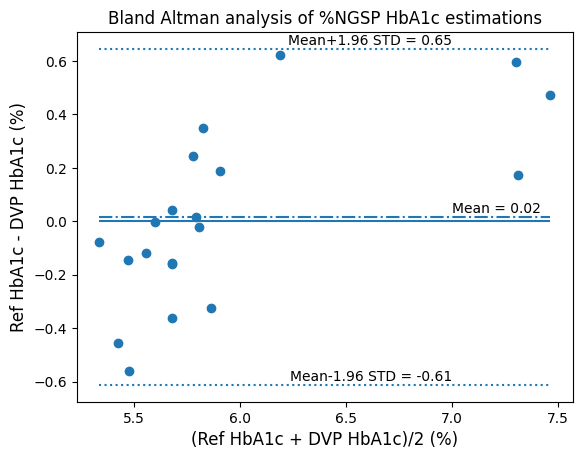

In [10]:
hBAA( b, a)

In [11]:
lg1=[5.338199071526896,
 5.605209392786757,
 5.883966987129025,
 5.622902547040188,
 5.938549185123755,
 5.640172739224134,
 5.553993075373299,
 7.322292805082853,
 5.78354139677647,
 7.187122623905713,
 5.728842749690309,
 5.651045185676551,
 5.808306361280205,
 7.548858590631226,
 5.390252259566268,
 5.670267158117015,
 5.340979299709738,
 5.9769061467581945,
 5.672420273734367,
 6.298014790615229]

In [12]:
lg2=[5.200000000000002,
 5.5,
 5.700000000000003,
 5.6,
 5.799999999999998,
 5.700000000000003,
 5.200000000000001,
 7.6000000000000005,
 6.0,
 7.400000000000001,
 5.799999999999999,
 5.9,
 6.0,
 7.700000000000002,
 5.399999999999999,
 5.600000000000001,
 5.3,
 5.5,
 5.600000000000001,
 6.5]

Mean:  0.0019078680125908854
+1.96 STD:  0.39112169124805113
-1.96 STD:  -0.3873059552228693
Bias:  0.0019078680125908854 +- 0.19857848124258176




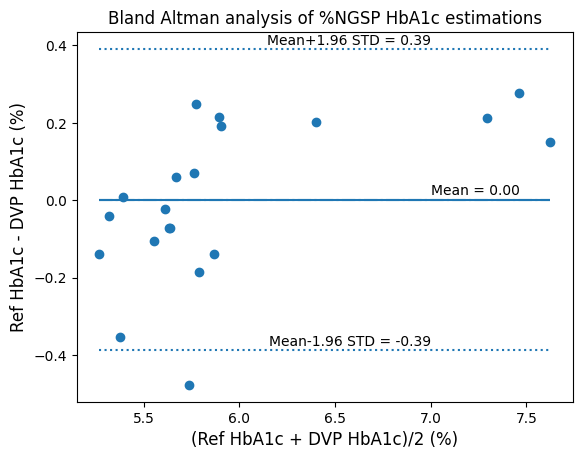

In [15]:
hBAA( lg2,lg1)

In [16]:
rf1= [6.024140976884259,
 5.509336318144682,
 5.7506980051832235,
 5.6433650699920275,
 5.770096982523651,
 5.700477332994795,
 5.591991603739389,
 6.882594562470776,
 5.866297500231186,
 6.9225821033338395,
 5.732249793545315,
 5.811750433056293,
 5.911866579757072,
 7.413973494638985,
 5.654536267199283,
 5.759398492997464,
 6.436759937394375,
 5.7525877216663295,
 5.78954408809753,
 5.918732559603448]

Mean:  -0.04214899117269573
+1.96 STD:  0.7760445549445683
-1.96 STD:  -0.8603425372899598
Bias:  -0.04214899117269573 +- 0.4174456867945225




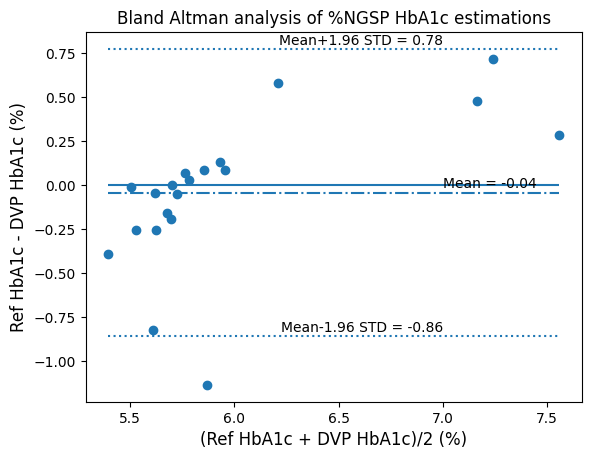

In [17]:
hBAA( lg2,rf1)

In [18]:
lg_woacdc=[5.249542372750184,
 5.7893784294150725,
 6.400598488752843,
 5.641225942998698,
 6.443610476665328,
 5.6395124578042335,
 5.907699362699188,
 6.85060376290969,
 6.078838152736708,
 7.121552461773166,
 6.07516311944257,
 5.851342709021766,
 5.9521591176866275,
 6.633843942081219,
 5.631278661896829,
 6.045653287087352,
 5.649765289987314,
 5.502760786261108,
 5.862445093994382,
 5.737127664089559]

Mean:  -0.053205079002691356
+1.96 STD:  0.8586208328405043
-1.96 STD:  -0.965030990845887
Bias:  -0.053205079002691356 +- 0.4652173019608141




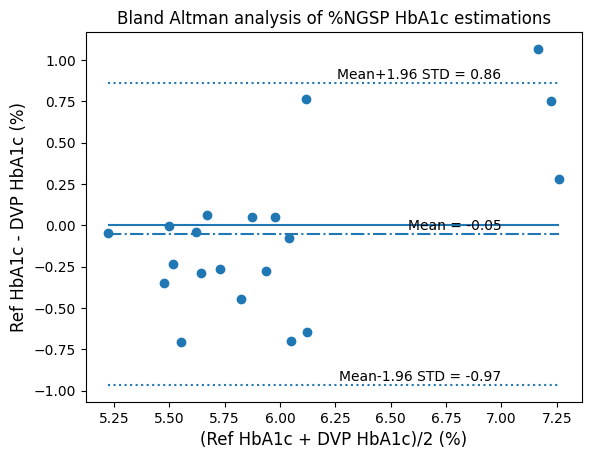

In [19]:
hBAA( lg2,lg_woacdc)

In [20]:
xg_woacdc=[5.3989816,
 5.7334886,
 6.2654333,
 5.689365,
 6.140331,
 5.714448,
 5.7200775,
 6.889855,
 5.922944,
 6.8544765,
 6.005756,
 5.722294,
 5.8341374,
 6.50758,
 5.587683,
 5.8145523,
 5.6892147,
 5.589423,
 5.76055,
 5.944217]

Mean:  0.01075960500000055
+1.96 STD:  0.855216470322594
-1.96 STD:  -0.833697260322593
Bias:  0.01075960500000055 +- 0.4308453394503028




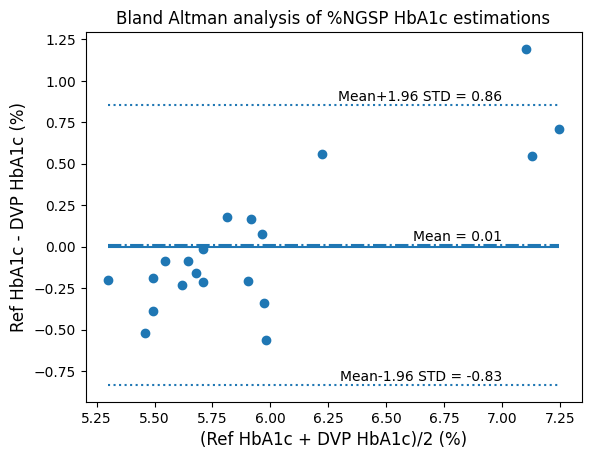

In [21]:
hBAA(lg2, xg_woacdc)

In [22]:
cb_woacdc= [5.43749436517056,
 6.234712031855178,
 6.5214214264788035,
 5.7524932912172115,
 6.261086172074591,
 5.554900959054796,
 5.875513176584502,
 6.410607959395438,
 5.904560800096413,
 7.005263749060997,
 6.0068296248205435,
 5.749988970228706,
 5.970452375660882,
 6.424154125162762,
 5.587284185140992,
 5.7399965273032905,
 6.044645557336239,
 5.624882505705151,
 5.744342937854243,
 5.842751844528533]

Mean:  -0.034669129236491084
+1.96 STD:  1.0663572181717915
-1.96 STD:  -1.1356954766447738
Bias:  -0.034669129236491084 +- 0.5617481364327973




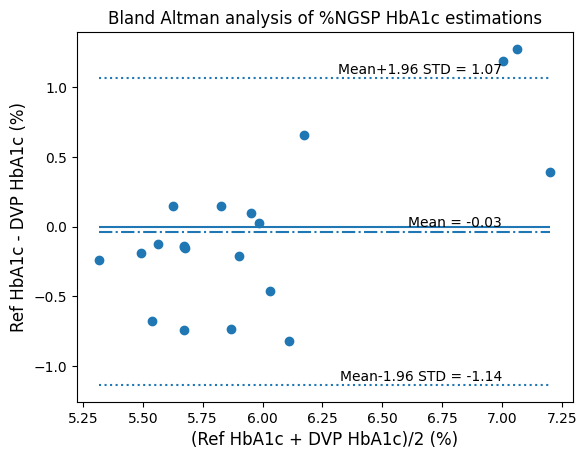

In [23]:
hBAA(lg2, cb_woacdc)

In [24]:
rf_woacdc= [5.603439748700605,
 6.053750413033531,
 6.366953351076537,
 5.5515871752304715,
 6.012967621099169,
 5.790098136373084,
 5.764986535475825,
 6.404249146121994,
 6.155076273290127,
 6.2294686110616695,
 6.028865952997011,
 5.867601765138453,
 5.671834655605139,
 6.786448000124833,
 5.608029861168968,
 5.947997256889046,
 5.6251925170529615,
 5.435465422521188,
 5.699216630398586,
 6.0863156123715285]

Mean:  0.015522765713464271
+1.96 STD:  1.0488927689813194
-1.96 STD:  -1.017847237554391
Bias:  0.015522765713464271 +- 0.5272295935040078




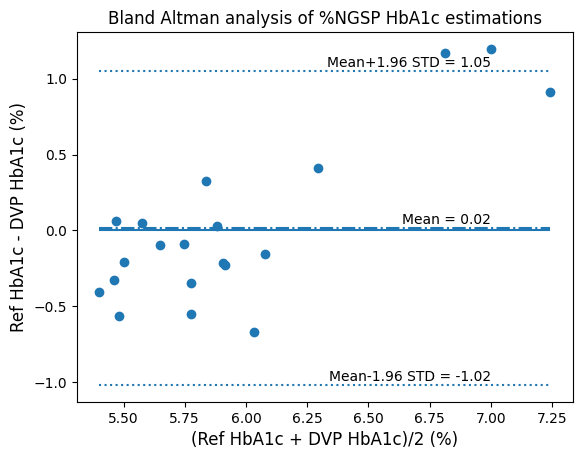

In [25]:
hBAA(lg2, rf_woacdc)

In [35]:
cb_f=[5.339286532622494,
 5.9559637365470595,
 6.2789940336215855,
 5.5801920827502896,
 6.093263506451016,
 5.590187954950921,
 5.586725872448054,
 7.2861318196712945,
 5.8409303493611455,
 7.293815705412007,
 5.945332799832986,
 5.703717004883868,
 5.82737818406059,
 7.566247737530769,
 5.938464976306872,
 5.973953845053946,
 5.827522937938668,
 5.613474176616885,
 5.735438142271913,
 6.0999373936801184]

In [36]:
cb2=[  5.2,5.8,5.9,5.6,5.8,5.7,5.2,7.6,6.0,7.4,5.8,5.9,6.0,7.7,5.4,6.2,6.4,5.5,5.6,6.5]

Mean:  0.006152060399375969
+1.96 STD:  0.5495151452052082
-1.96 STD:  -0.5372110244064562
Bias:  0.006152060399375969 +- 0.277226063676445




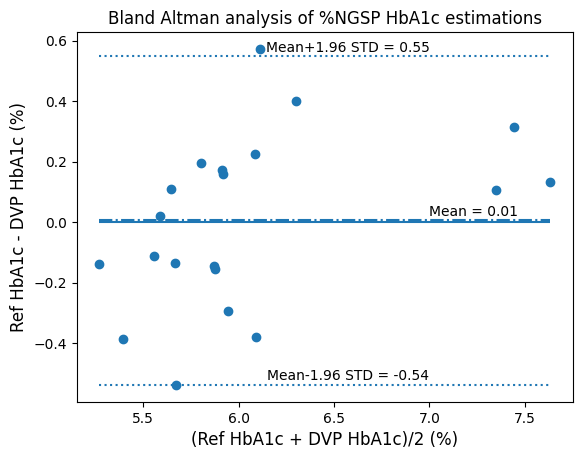

In [37]:
hBAA(cb2, cb_f)

In [38]:
rf_f=[5.928806015843567,
 5.801367437138941,
 5.9797913032792485,
 5.598748449853364,
 5.711607884914655,
 5.5408225081267934,
 5.8297823363093,
 7.65301557115897,
 5.848030832771026,
 7.585918932247432,
 5.862498901901851,
 5.778114650186416,
 5.9281665651531945,
 7.615969769616955,
 5.80034734675818,
 6.412378918086727,
 5.987405610596516,
 5.606641611171177,
 5.753970678664317,
 6.453478294361366]

Mean:  -0.07384318090699984
+1.96 STD:  0.4377437453384484
-1.96 STD:  -0.585430107152448
Bias:  -0.07384318090699984 +- 0.2610137378803307




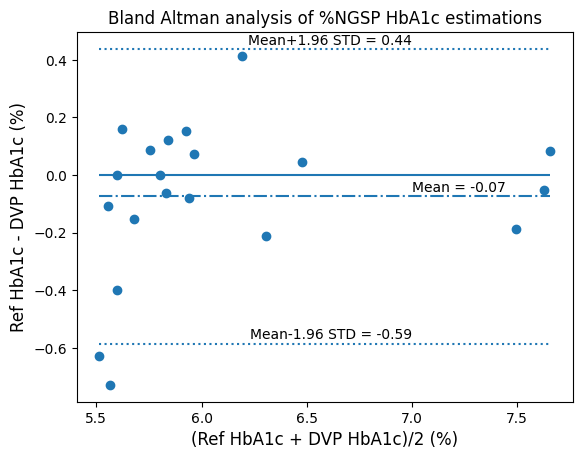

In [39]:
hBAA(cb2, rf_f)

In [40]:
xg_f=[5.3940587,
 5.8252645,
 6.1162295,
 5.603846,
 5.8837485,
 5.584052,
 5.944224,
 7.3448443,
 5.8610506,
 7.4579415,
 5.866684,
 5.7413864,
 5.6848936,
 7.5208898,
 5.752505,
 6.027,
 5.6816897,
 5.58749,
 5.8126636,
 6.019105]

Mean:  0.02452166500000006
+1.96 STD:  0.6206988998930305
-1.96 STD:  -0.5716555698930303
Bias:  0.02452166500000006 +- 0.30417205861889307




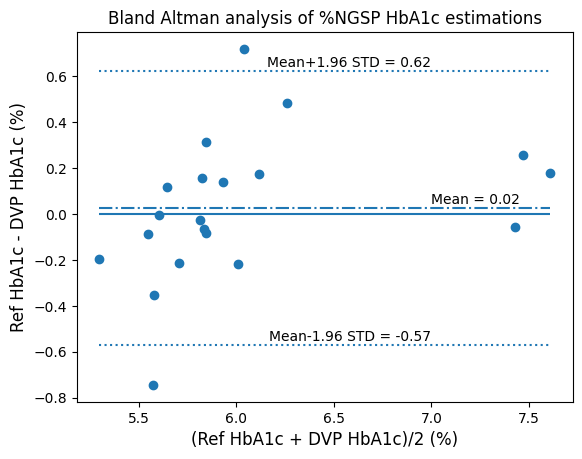

In [41]:
hBAA(cb2,xg_f)

In [42]:
cbwo_acdc=[5.541100079955663,
 6.324237667059016,
 6.08916503793875,
 5.698828821767184,
 5.935386643239283,
 5.737020541518265,
 5.995480889456181,
 6.798309888256042,
 5.916017105788739,
 7.13618593304221,
 6.167843585694176,
 6.057822577600409,
 5.771373937745155,
 7.0855969454931875,
 5.632201528929503,
 6.524797679511568,
 5.595744460122677,
 5.449294233158699,
 5.950712840826792,
 6.002303301505006]

Mean:  -0.01047118493042527
+1.96 STD:  0.8182946519743826
-1.96 STD:  -0.8392370218352332
Bias:  -0.01047118493042527 +- 0.42283971270653464




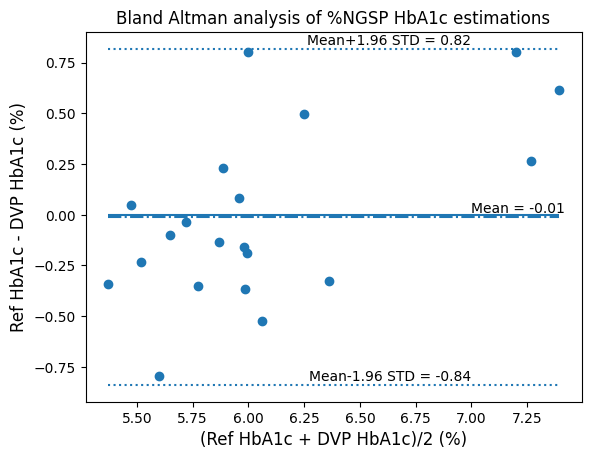

In [43]:
hBAA(cb2,cbwo_acdc)

In [44]:
rfwo_acdc = [5.635269515725736,
 5.73205067253045,
 6.296879772999522,
 5.576919418588501,
 6.016793911317805,
 5.890712827861691,
 5.995097024452388,
 7.176318037639481,
 5.894192371926313,
 6.577498102057573,
 6.10748425544017,
 6.408394400590667,
 5.740434916588121,
 6.919190272202579,
 5.651157392945671,
 6.972132915860945,
 5.784334723238738,
 5.490299780484854,
 5.921382549170723,
 6.2288770835666885]

Mean:  -0.040770997259430744
+1.96 STD:  0.8517168393375115
-1.96 STD:  -0.9332588338563731
Bias:  -0.040770997259430744 +- 0.4553509370392563




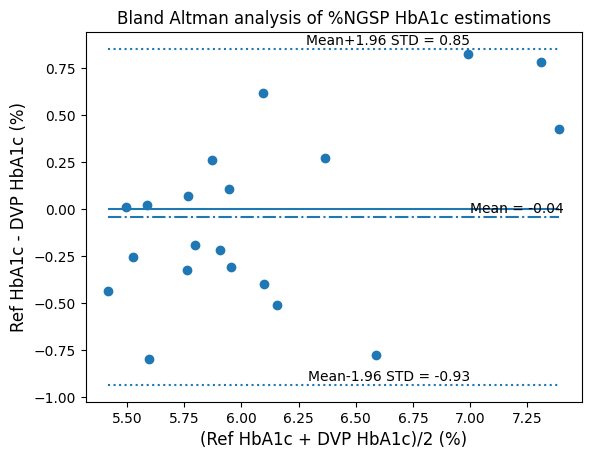

In [45]:
hBAA(cb2, rfwo_acdc)

In [46]:
xgwo_acdc=[5.7385674,
 6.233591,
 6.2997327,
 5.6335926,
 5.929996,
 5.739368,
 6.0532384,
 7.0704827,
 5.9882917,
 7.130999,
 6.302011,
 5.924859,
 5.60539,
 6.930186,
 5.618457,
 6.652437,
 5.63616,
 5.5220003,
 6.385588,
 6.014536]

Mean:  -0.06047418999999996
+1.96 STD:  0.8541683332243639
-1.96 STD:  -0.9751167132243639
Bias:  -0.06047418999999996 +- 0.4666543485838591




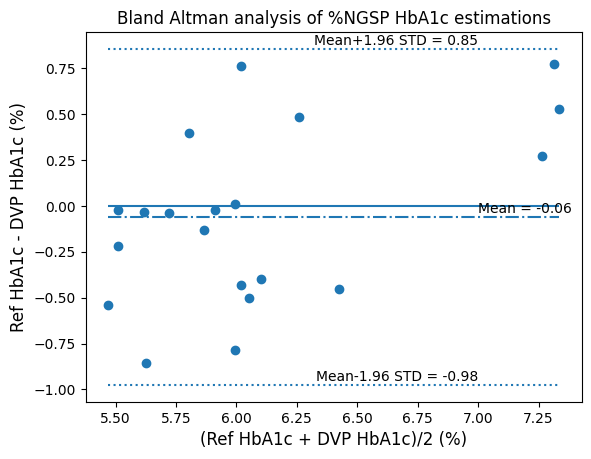

In [47]:
hBAA(cb2, xgwo_acdc)

In [48]:
lg_f=[5.283045403932082,
 5.8821189566054795,
 6.110360896627259,
 5.643604923415313,
 5.928763040223321,
 5.603555960310551,
 5.595169071357962,
 7.384614551227109,
 5.868069124445077,
 7.440237259810076,
 5.798559536291121,
 5.765145232355836,
 5.919916213025021,
 7.61108926891991,
 6.01620850565463,
 5.8286478409908415,
 5.891326113528437,
 5.65462508426814,
 5.676456169009587,
 6.23423306401995]

Mean:  0.0032126891991149263
+1.96 STD:  0.4865623191899798
-1.96 STD:  -0.4801369407917499
Bias:  0.0032126891991149263 +- 0.24660695407697186




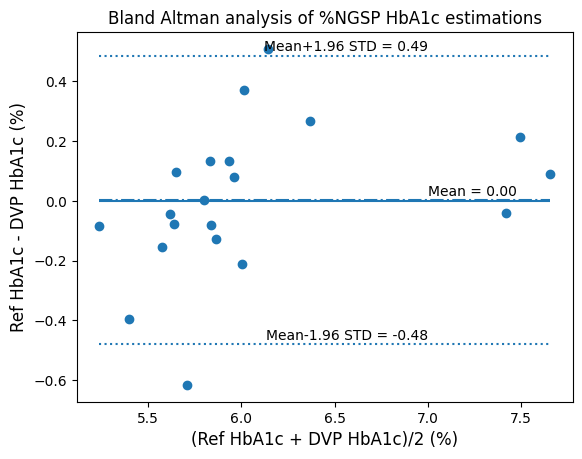

In [49]:
hBAA(cb2, lg_f)